In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (12,10)

In [84]:
str_files = ''
#Carrega os dados do arquivo .csv
ugrhi06 = pd.read_csv(str_files + "cetesb_concatenado06semoutliers.csv",encoding='utf-8',sep=',',index_col=[0])

#Carrega os dados do arquivo .csv
ugrhi10 = pd.read_csv(str_files + "cetesb_concatenado10semoutliers.csv",encoding='utf-8',sep=',')
ugrhi10

,solido,ph,coliformes,dbo,fosforo,od,temperatura,turbidez
0,189.791667,7.094057,3535.833333,4.916667,1.084160,2.471667,21.791667,27.641667
1,192.118607,7.105961,3439.495434,4.788813,1.084160,2.442676,21.951484,27.898333
2,194.694863,7.105961,3332.835616,4.647260,1.084160,2.410579,22.128425,28.182500
3,197.188014,7.120679,3229.616438,4.510274,1.084160,2.379517,22.299658,28.457500
4,199.764269,7.120679,3122.956621,4.368721,1.084160,2.347420,22.476598,28.741667
...,...,...,...,...,...,...,...,...
497,361.506122,7.136287,5700.000000,7.481633,0.197539,3.799184,24.995918,28.922449
498,345.626531,7.136287,5700.000000,8.620408,0.195135,3.849796,25.248980,33.730612
499,329.746939,7.206898,5700.000000,9.759184,0.192731,3.900408,25.502041,38.538776
500,314.379592,7.134653,5700.000000,10.861224,0.190404,3.949388,25.746939,43.191837


In [59]:
print('---- Tamanho dos conjuntos originais ----')
print('ugrhi06:',len(ugrhi06))
print('ugrhi10:',len(ugrhi10))

#Seleciona os dados equivalente ao tamanho da URGHI10
ugrhi06 = ugrhi06.iloc[0:len(ugrhi10)]

#Seleciona os valores da coluna ph da URGHI06, na qual será utilizado para a normalização dos dados quando apresentar o gráfico
#train_previsao = ugrhi06['ph'].values
#train_previsao = train_previsao.reshape(len(train_previsao),1)

print('---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----')
print('ugrhi06:',len(ugrhi06))
print('ugrhi10:',len(ugrhi10))

---- Tamanho dos conjuntos originais ----
ugrhi06: 503
ugrhi10: 502
---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----
ugrhi06: 502
ugrhi10: 502


In [101]:
def pega_index_coluna_ugrhi10(p):
    
    index_coluna = 0
    
    if (p == 'solido'):
        index_coluna = 0
    elif (p == 'ph'):
        index_coluna = 1
    elif (p == 'coliformes'):
        index_coluna = 2 
    elif (p == 'dbo'):
        index_coluna = 3
    elif (p == 'fosforo'):
        index_coluna = 4
    elif (p == 'od'):
        index_coluna = 5 
    elif (p == 'temperatura'):
        index_coluna = 6 
    elif (p == 'turbidez'):
        index_coluna = 7
        
    return index_coluna

def pegar_dados_coluna_predita_train_test(trainingd,percent,index_coluna):
    data = trainingd.iloc[:,:].values
    train = trainingd.iloc[0:int(len(data)*percent),:].values  
    train_previsao = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
    test = trainingd.iloc[len(train):,index_coluna:index_coluna+1].values
    
    return train,train_previsao, test

def pegar_dados_coluna_predita_train_test_od(trainingd,percent,index_coluna):
    data = trainingd.iloc[:,:].values
    train = trainingd.iloc[0:int(len(data)*percent),:].values  
    train_previsao = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
    test = trainingd.iloc[len(train):,index_coluna:index_coluna+1].values
    
    return train,train_previsao, test

#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
def normalizacao(train,test):
    sc = MinMaxScaler()
    testd = test
    train = sc.fit_transform(train)
    test = sc.fit_transform(test)    
    return train,test,testd

#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
#cy = coluna que será predita
def prepara_dados(dados,lags,cy):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i,:])
        y.append(dados[i, cy])
       
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(y_pred,y_true):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    '''  
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        
        print(real)
        mape = mape_sum/len(real)
    '''
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

def rquadrado(y_pred,y_true):
    #Soma Total dos Quadrados (STQ): mostra a variação de y em torno da própria média. 
    #É o somatório das diferenças entre o valor alvo real e sua média elevado ao quadrado.
    y_traco = np.mean(y_true)
    
    print('media y_true:', y_traco)
        
    stq = 0
    
    for s in y_true:
        a = s - y_traco
        st = a * a
        stq = stq + st
    
    print('Soma Total dos Quadrados (STQ):', stq[0])
    
    #Soma dos Quadrados dos Resíduos (SQU): variação de Y que não é explicada pelo modelo elaborado. 
    #É o somatório das diferenças entre o valor predito e o valor real elevados ao quadrado.
    squ = 0
    
    y_traco = np.mean(y_pred)
    print('media y_pred:', y_traco)
    
    for n in range(len(y_true)):
        a = y_true[n] - y_pred[n]
        st = a * a
        squ = squ + st
        
    print('Soma dos Quadrados dos Resíduos (SQU):',squ[0])
    print('\n')
    print('Fórmula do R²')
    print('\n')
    print('sqr = stq - squ')
    sqr = stq[0] - squ[0]
    print('R² = sqr/stq')
    sqr = sqr/stq[0]
    print('\n')
    return sqr

def correlacao_determinacao(dtframe,tipo):
    
    if (tipo == 0): #Treino
        resultado = dtframe.corr().previsao_treino.values[1] ** 2 
    else: #teste
        resultado = dtframe.corr().previsao_teste.values[1] ** 2
    
    return resultado

def ajusta_array(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
        
    #print('ajusta array:',lista)
        
    return lista

def ajusta_lista(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
        
    #print('ajusta array:',lista)
        
    return lista

In [108]:
df_resultado_medio_g = pd.DataFrame()

index_coluna = 0

parametro = []
tecnica   = []

#média
media_parametro_mape_treino = []
media_parametro_rmse_treino = []
media_parametro_r_treino    = []
    
media_parametro_mape_teste  = []
media_parametro_rmse_teste  = []
media_parametro_r_teste     = []
    
#desvio_padrão
    
std_parametro_mape_treino = []
std_parametro_rmse_treino = []
std_parametro_r_treino    = []
    
std_parametro_mape_teste  = []
std_parametro_rmse_teste  = []
std_parametro_r_teste     = []

for p in ('ph','coliformes', 'dbo','fosforo','od','solido','temperatura','turbidez'):
    
    print('Agora é a vez do parâmetro:', p)
   
    df_resultados_treino = pd.DataFrame()
    df_resultados_teste  = pd.DataFrame()
    df_resultados        = pd.DataFrame()
    
    media_lag_mape_treino = []
    media_lag_rmse_treino = []
    media_lag_r_treino    = []
        
    media_lag_mape_teste = []
    media_lag_rmse_teste = []
    media_lag_r_teste    = []
    
    index_coluna_10 = pega_index_coluna_ugrhi10(p)
    
    #seleciona os dados
    
    train06,train_previsao06, test06 = pegar_dados_coluna_predita_train_test(ugrhi06,0.70,index_coluna) 
    train10,train_previsao10, test10 = pegar_dados_coluna_predita_train_test(ugrhi10,0.70,index_coluna_10)
    
    #print(test10)
    
    #normalização dos dados
    train06,test06,testd06 = normalizacao(train06,test06)
    train10,test10,testd10 = normalizacao(train10,test10)
        
    normalizador_previsao = MinMaxScaler()
    sc = MinMaxScaler()
    normalizador_previsao.fit_transform(train_previsao06)
            
    for l in range(1, 16):
    
        lags = l        
    
        #Prepara os dados de treinamento -ugrhi06
        #Vai predizer o valor da coluna 4 (valor ph)
        train_X06, train_y06 = prepara_dados(train06, lags,index_coluna)
        
        #Prepara os dados de teste
        entradas06 = ugrhi06[len(ugrhi06) - len(test06) - lags:].values
        entradas06 = sc.fit_transform(entradas06)   
    
        test_X06 = []
        for i in range(lags, lags+len(test06)):
            test_X06.append(entradas06[i-lags:i, 0:8])
        test_X06 = np.array(test_X06)
    
        #Ajusta a dimensão de test_X06 e train_X06
        nsamples, nx, ny = test_X06.shape
        test_X06 = test_X06.reshape((nsamples,nx*ny))
    
        nsamples, nx, ny = train_X06.shape
        train_X06 = train_X06.reshape((nsamples,nx*ny))
    
        #Prepara os dados de treinamento -ugrhi10
        #Aqui vamos pegar test_X10.
        train_X10, train_y10 = prepara_dados(train10, lags,index_coluna_10)
        
        #Prepara os dados de teste
        entradas10 = ugrhi10[len(ugrhi10) - len(test10) - lags:].values
        entradas10 = sc.fit_transform(entradas10)   
    
        test_X10 = []
        for i in range(lags, lags+len(test10)):
            test_X10.append(entradas10[i-lags:i, 0:8])
        test_X10 = np.array(test_X10)
    
        #Ajusta a dimensão de test_X10 
        nsamples, nx, ny = test_X10.shape
        test_X10 = test_X10.reshape((nsamples,nx*ny))
    
        nsamples, nx, ny = train_X10.shape
        train_X10 = train_X10.reshape((nsamples,nx*ny))
        
        #Cria o modelo
        model = LinearRegression(normalize=True)
    
        #Treina o modelo
        model.fit(train_X06,train_y06)
        score = model.score(train_X06,train_y06)
        #print(score)

        #Dados de teste
        previsoes = model.predict(test_X10)
        previsoes = previsoes.reshape(-1, 1)
        previsoes = normalizador_previsao.inverse_transform(previsoes)
    
        '''   
        print('Teste - Gráficos com lag', l)
    
        #Plotagem do gráfico
        plt.plot(testd10,color='red',label = 'Observado')
        plt.plot(previsoes,color='blue',label = 'Previsoes')
        plt.xlabel('Tempo')
        plt.ylabel('Valor pH')
        plt.legend()
        plt.show()
        '''    
    
        #Dados de treino
        previsoes_treino = model.predict(train_X10)
        previsoes_treino = previsoes_treino.reshape(-1, 1)
        previsoes_treino = normalizador_previsao.inverse_transform(previsoes_treino)
       
        '''
        print('Treinamento - Gráficos com lag', l)
    
        #Plotagem do gráfico
        plt.plot(train_previsao10,color='red',label = 'Observado')
        plt.plot(previsoes_treino,color='blue',label = 'Previsoes')
        plt.xlabel('Tempo')
        plt.ylabel('Valor pH')
        plt.legend()
        plt.show()
        '''
            
        treino = train_previsao10[lags: len(previsoes_treino) + lags, :]
        observado_test = testd10
        
                            
        observado_treino = train_previsao10
    
        treino         = ajusta_array(treino)
        observado_test = ajusta_array(observado_test)
        
        #print(observado_test)
        
               
        #Calculo do erro da previsão MAPE, RMSE e R²
    
        observado_treino_d = observado_treino
        previsoes_treino_d = previsoes_treino
        previsoes_d        = previsoes
        
        #print(observado_test)
                
        mape_treino_d        = round(mape(previsoes_treino,treino),4)
        rmse_treino_d        = round(rmse(previsoes_treino,treino),4)
        #r_treino_d           = round(r2(previsoes_treino,treino),4)
        
        mape_teste_d        = round(mape(previsoes,observado_test),4)
        rmse_teste_d        = round(rmse(previsoes,observado_test),4)
        #r_teste_d           = round(r2(previsoes,observado_test),4) 
    
        #print('mape_teste:',mape_teste_d)
       
        df_corr_determinacao_treino = pd.DataFrame()
        df_corr_determinacao_teste  = pd.DataFrame()
    
        #print('previsao_treino:', previsoes_treino)
    
        #Calcula o coeficiente de determinação
        dict = {'previsao_treino': ajusta_lista(previsoes_treino), 'treino': treino} 
    
        df_treino = pd.DataFrame(dict)
        dframes_treino = [df_corr_determinacao_treino,df_treino]
        df_corr_determinacao_treino = pd.concat(dframes_treino)
    
        dict = {'previsao_teste': ajusta_lista(previsoes), 'teste': observado_test} 
            
        df_teste = pd.DataFrame(dict)
        dframes_teste = [df_corr_determinacao_teste,df_teste]
        df_corr_determinacao_teste = pd.concat(dframes_teste)
    
        r_treino_d = []
        r_teste_d  = []
    
        r_treino_d.append(round(correlacao_determinacao(df_corr_determinacao_treino,0),2))
        r_teste_d.append(round(correlacao_determinacao(df_corr_determinacao_teste,1),2))
        
        media_lag_mape_treino.append(np.mean(mape_treino_d))
        media_lag_rmse_treino.append(np.mean(rmse_treino_d))
        media_lag_r_treino.append(np.mean(r_treino_d))
        
        media_lag_mape_teste.append(np.mean(mape_teste_d))
        media_lag_rmse_teste.append(np.mean(rmse_teste_d))
        media_lag_r_teste.append(np.mean(r_teste_d))
        
    index_coluna = index_coluna + 1        
                
    #média
    media_parametro_mape_treino.append(np.mean(media_lag_mape_treino))
    media_parametro_rmse_treino.append(np.mean(media_lag_rmse_treino))
    media_parametro_r_treino.append(np.mean(media_lag_r_treino))
    
    media_parametro_mape_teste.append(np.mean(media_lag_mape_teste))
    media_parametro_rmse_teste.append(np.mean(media_lag_rmse_teste))
    media_parametro_r_teste.append(np.mean(media_lag_r_teste))
        
    #desvio_padrão
    
    #std_parametro_mape_treino.append(np.std(media_lag_mape_treino))
    std_parametro_rmse_treino.append(np.std(media_lag_rmse_treino))
    #std_parametro_r_treino.append(np.std(media_lag_r_treino))
    
    #std_parametro_mape_teste.append(np.std(media_lag_mape_teste))
    std_parametro_rmse_teste.append(np.std(media_lag_rmse_teste))
    #std_parametro_r_teste.append(np.std(media_lag_r_teste))
        
    parametro.append(p)
    tecnica.append('RL (Todas var.)')

dict = {'tecnica': tecnica,
        'parametro': parametro,
        'mape_treino':  media_parametro_mape_treino, 
        'rmse_treino':  media_parametro_rmse_treino, 'std_rmse_treino':  std_parametro_rmse_treino,
        'r_quad_treino':media_parametro_r_treino,    
        'mape_teste':   media_parametro_mape_teste,  
        'rmse_teste':   media_parametro_rmse_teste,  'std_rmse_teste':   std_parametro_rmse_teste,
        'r_quad_teste': media_parametro_r_teste}
   
df_resultado_final = pd.DataFrame(dict)

dframes = [df_resultado_medio_g,df_resultado_final]
df_resultado_medio_g = pd.concat(dframes)

df_resultado_medio_g.round(2)

Agora é a vez do parâmetro: ph
1
Agora é a vez do parâmetro: coliformes
2
Agora é a vez do parâmetro: dbo
3
Agora é a vez do parâmetro: fosforo
4
Agora é a vez do parâmetro: od
5
Agora é a vez do parâmetro: solido
0
Agora é a vez do parâmetro: temperatura
6
Agora é a vez do parâmetro: turbidez
7


,tecnica,parametro,mape_treino,rmse_treino,std_rmse_treino,r_quad_treino,mape_teste,rmse_teste,std_rmse_teste,r_quad_teste
0,RL (Todas var.),ph,7.02,0.54,0.01,0.01,6.52,0.50,0.02,0.01
1,RL (Todas var.),coliformes,3782148.27,1989855.10,47889.20,0.01,5460945.59,2227843.16,149709.86,0.04
2,RL (Todas var.),dbo,139.25,13.33,0.87,0.00,121.16,11.75,1.74,0.06
3,RL (Todas var.),fosforo,158.61,0.55,0.05,0.03,213.09,0.61,0.05,0.00
4,RL (Todas var.),od,55.89,2.76,0.08,0.01,49.52,2.25,0.14,0.00
5,RL (Todas var.),solido,27.36,81.13,9.35,0.00,26.05,93.06,8.65,0.00
6,RL (Todas var.),temperatura,9.39,2.61,0.22,0.05,11.73,3.35,0.30,0.05
7,RL (Todas var.),turbidez,60.26,16.86,1.41,0.04,59.91,20.64,1.94,0.02


In [109]:
df_resultado_medio_g.round(2).to_csv (r'C:\Users\Anderson\predicaoagua\src\src_dissertação\resultados\rl_espaco_temporal_todas_var.csv', index = True, header=True)

In [22]:
df_resultados_treino = pd.DataFrame()
df_resultados_teste = pd.DataFrame()
df_resultados = pd.DataFrame()

#lags = (3,5,7) 
#for l in range(1, 9, 2):
for l in range(1, 21):
    
    lags = l
    
    #seleciona os dados
    
    train06,train_previsao06, test06 = pegar_dados_coluna_predita_train_test_od(ugrhi06,0.70,4) 
    train10,train_previsao10, test10 = pegar_dados_coluna_predita_train_test_od(ugrhi10,0.70,5) 
    
    #normalização dos dados
    train06,test06,testd06 = normalizacao(train06,test06)
    train10,test10,testd10 = normalizacao(train10,test10)
    
    normalizador_previsao = MinMaxScaler()
    sc = MinMaxScaler()
    normalizador_previsao.fit_transform(train_previsao06)
    
    #Prepara os dados de treinamento -ugrhi06
    #Vai predizer o valor da coluna 4 (valor ph)
    train_X06, train_y06 = prepara_dados(train06, lags,4)
        
    #Prepara os dados de teste
    entradas06 = ugrhi06[len(ugrhi06) - len(test06) - lags:].values
    entradas06 = sc.fit_transform(entradas06)   
    
    test_X06 = []
    for i in range(lags, lags+len(test06)):
        test_X06.append(entradas06[i-lags:i, 0:8])
    test_X06 = np.array(test_X06)
    
    #Ajusta a dimensão de test_X06 e train_X06
    nsamples, nx, ny = test_X06.shape
    test_X06 = test_X06.reshape((nsamples,nx*ny))
    
    nsamples, nx, ny = train_X06.shape
    train_X06 = train_X06.reshape((nsamples,nx*ny))
    
    #Prepara os dados de treinamento -ugrhi10
    #Aqui vamos pegar test_X10.
    train_X10, train_y10 = prepara_dados(train10, lags,5)
        
    #Prepara os dados de teste
    entradas10 = ugrhi10[len(ugrhi10) - len(test10) - lags:].values
    entradas10 = sc.fit_transform(entradas10)   
    
    test_X10 = []
    for i in range(lags, lags+len(test10)):
        test_X10.append(entradas10[i-lags:i, 0:8])
    test_X10 = np.array(test_X10)
    
    #Ajusta a dimensão de test_X10 
    nsamples, nx, ny = test_X10.shape
    test_X10 = test_X10.reshape((nsamples,nx*ny))
    
    nsamples, nx, ny = train_X10.shape
    train_X10 = train_X10.reshape((nsamples,nx*ny))
        
    #Cria o modelo
    model = LinearRegression(normalize=True)
    
    #Treina o modelo
    model.fit(train_X06,train_y06)
    score = model.score(train_X06,train_y06)
    #print(score)

    #Dados de teste
    previsoes = model.predict(test_X10)
    previsoes = previsoes.reshape(-1, 1)
    previsoes = normalizador_previsao.inverse_transform(previsoes)
       
    print('Teste - Gráficos com lag', l)
    '''
    #Plotagem do gráfico
    plt.plot(testd10,color='red',label = 'Observado')
    plt.plot(previsoes,color='blue',label = 'Previsoes')
    plt.xlabel('Tempo')
    plt.ylabel('Valor pH')
    plt.legend()
    plt.show()
    '''    
    
    #Dados de treino
    previsoes_treino = model.predict(train_X10)
    previsoes_treino = previsoes_treino.reshape(-1, 1)
    previsoes_treino = normalizador_previsao.inverse_transform(previsoes_treino)
    
    
    print('Treinamento - Gráficos com lag', l)
    '''
    #Plotagem do gráfico
    plt.plot(train_previsao10,color='red',label = 'Observado')
    plt.plot(previsoes_treino,color='blue',label = 'Previsoes')
    plt.xlabel('Tempo')
    plt.ylabel('Valor pH')
    plt.legend()
    plt.show()
    '''
            
    treino = train_previsao10[lags: len(previsoes_treino) + lags, :]
    observado_test = testd10
    
    observado_treino = train_previsao10
    
    treino         = ajusta_array(treino)
    observado_test = ajusta_array(observado_test)
               
    #Calculo do erro da previsão MAPE, RMSE e R²
    
    observado_treino_d = observado_treino
    previsoes_treino_d = previsoes_treino
    previsoes_d        = previsoes
        
    mape_treino_d        = round(mape(previsoes_treino,treino),4)
    rmse_treino_d        = round(rmse(previsoes_treino,treino),4)
    #r_treino_d           = round(r2(previsoes_treino,treino),4)
        
    mape_teste_d        = round(mape(previsoes,observado_test),4)
    rmse_teste_d        = round(rmse(previsoes,observado_test),4)
    #r_teste_d           = round(r2(previsoes,observado_test),4) 
    
    #print('treino:',treino)
       
    df_corr_determinacao_treino = pd.DataFrame()
    df_corr_determinacao_teste  = pd.DataFrame()
    
    #print('previsao_treino:', previsoes_treino)
    
    #Calcula o coeficiente de determinação
    dict = {'previsao_treino': ajusta_lista(previsoes_treino), 'treino': treino} 
    
    df_treino = pd.DataFrame(dict)
    dframes_treino = [df_corr_determinacao_treino,df_treino]
    df_corr_determinacao_treino = pd.concat(dframes_treino)
    
    dict = {'previsao_teste': ajusta_lista(previsoes), 'teste': observado_test} 
    
    df_teste = pd.DataFrame(dict)
    dframes_teste = [df_corr_determinacao_teste,df_teste]
    df_corr_determinacao_teste = pd.concat(dframes_teste)
    
    r_treino_d = []
    r_teste_d  = []
    
    r_treino_d.append(round(correlacao_determinacao(df_corr_determinacao_treino,0),4))
    r_teste_d.append(round(correlacao_determinacao(df_corr_determinacao_teste,1),4))
    
    lag_treino = []
    lag_teste = []
    
    lag_treino.append(lags)
    lag_teste.append(lags)
        
    # dictionary of lists  
    
    dict = {'lags_treino': lag_treino, 'mape_treino': mape_treino_d, 'rmse_treino': rmse_treino_d,'r_quad_treino':r_treino_d,
            'lags_teste': lag_teste, 'mape_teste': mape_teste_d, 'rmse_teste': rmse_teste_d,'r_quad_teste':r_teste_d} 
    
    df_result = pd.DataFrame(dict)
    dframes = [df_resultados,df_result]
    df_resultados = pd.concat(dframes)  
    
df_resultados.describe()

Teste - Gráficos com lag 1
Treinamento - Gráficos com lag 1
Teste - Gráficos com lag 2
Treinamento - Gráficos com lag 2
Teste - Gráficos com lag 3
Treinamento - Gráficos com lag 3
Teste - Gráficos com lag 4
Treinamento - Gráficos com lag 4
Teste - Gráficos com lag 5
Treinamento - Gráficos com lag 5
Teste - Gráficos com lag 6
Treinamento - Gráficos com lag 6
Teste - Gráficos com lag 7
Treinamento - Gráficos com lag 7
Teste - Gráficos com lag 8
Treinamento - Gráficos com lag 8
Teste - Gráficos com lag 9
Treinamento - Gráficos com lag 9
Teste - Gráficos com lag 10
Treinamento - Gráficos com lag 10
Teste - Gráficos com lag 11
Treinamento - Gráficos com lag 11
Teste - Gráficos com lag 12
Treinamento - Gráficos com lag 12
Teste - Gráficos com lag 13
Treinamento - Gráficos com lag 13
Teste - Gráficos com lag 14
Treinamento - Gráficos com lag 14
Teste - Gráficos com lag 15
Treinamento - Gráficos com lag 15
Teste - Gráficos com lag 16
Treinamento - Gráficos com lag 16
Teste - Gráficos com lag 1

,lags_treino,mape_treino,rmse_treino,r_quad_treino,lags_teste,mape_teste,rmse_teste,r_quad_teste
count,20.00000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000
mean,10.50000,56.777550,2.79290,0.008935,10.50000,50.724860,2.301690,0.001125
std,5.91608,2.574002,0.09839,0.008830,5.91608,3.886310,0.156301,0.001004
min,1.00000,52.611000,2.64840,0.000100,1.00000,43.363500,2.004100,0.000100
25%,5.75000,54.709100,2.71005,0.001000,5.75000,47.752075,2.186450,0.000475
50%,10.50000,56.731150,2.79125,0.006550,10.50000,50.770800,2.305100,0.000850
75%,15.25000,58.764950,2.86530,0.018525,15.25000,53.926475,2.441275,0.001450
max,20.00000,62.222400,3.00730,0.024100,20.00000,57.489100,2.550100,0.004400


In [7]:
df_resultados

,lags_treino,mape_treino,rmse_treino,r_quad_treino,lags_teste,mape_teste,rmse_teste,r_quad_teste
0,1,6.9910,0.5286,0.0061,1,6.9096,0.5210,0.0079
0,2,7.0610,0.5299,0.0077,2,6.9712,0.5174,0.0164
0,3,7.1619,0.5377,0.0087,3,6.9665,0.5176,0.0122
0,4,7.1029,0.5334,0.0090,4,6.9452,0.5177,0.0077
0,5,7.1307,0.5367,0.0036,5,6.8171,0.5124,0.0094
0,6,7.3037,0.5487,0.0073,6,6.9185,0.5198,0.0054
0,7,7.2976,0.5520,0.0148,7,6.4754,0.4885,0.0023
0,8,7.2901,0.5512,0.0154,8,6.5322,0.4937,0.0029
0,9,7.0291,0.5357,0.0235,9,6.0905,0.4682,0.0012
0,10,6.9947,0.5377,0.0245,10,5.8008,0.4509,0.0025


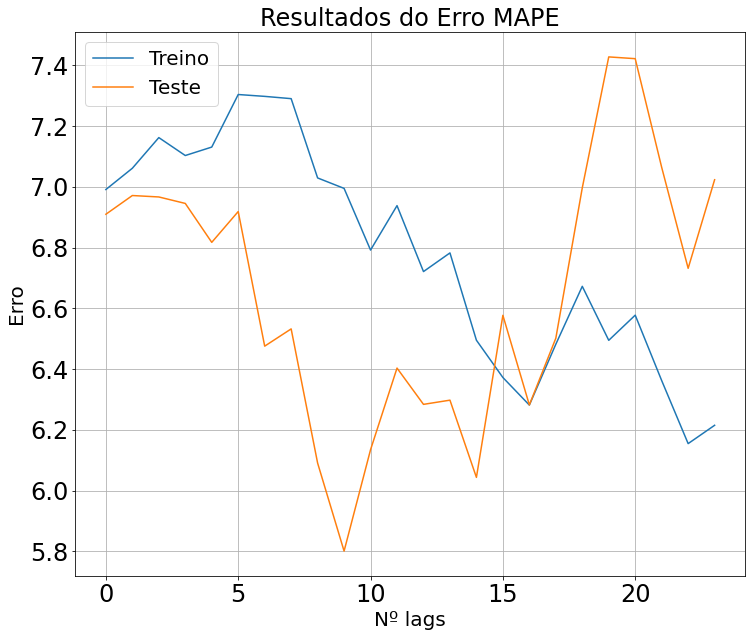

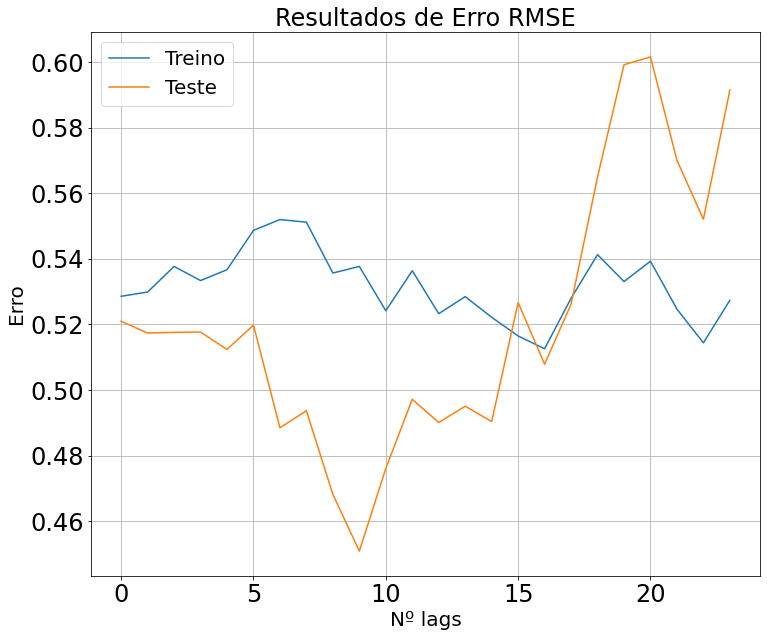

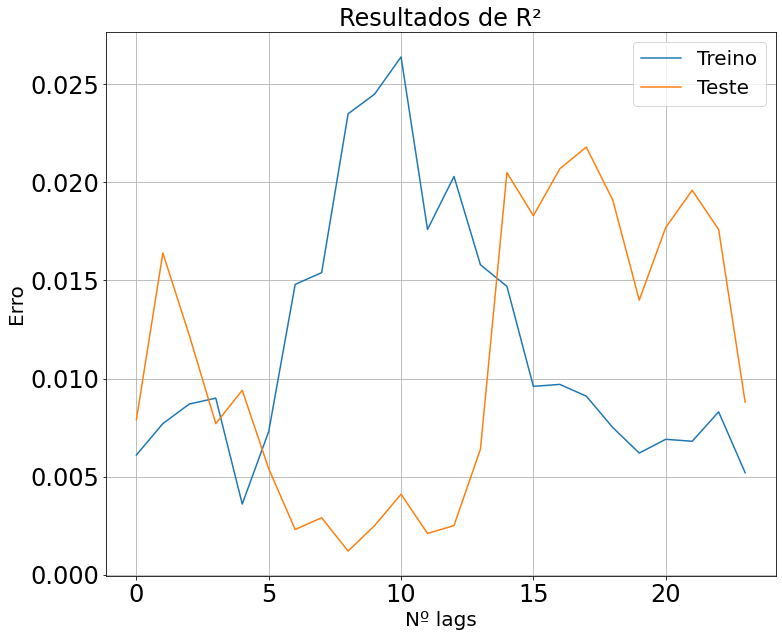

In [8]:
plt.plot(df_resultados.mape_treino.values,label = 'Treino')
plt.plot(df_resultados.mape_teste.values,label  = 'Teste')
plt.xlabel('Nº lags')
plt.ylabel('Erro')
plt.title('Resultados do Erro MAPE')
plt.legend()
plt.grid()
plt.show()

plt.plot(df_resultados.rmse_treino.values,label = 'Treino')
plt.plot(df_resultados.rmse_teste.values,label  = 'Teste')
plt.xlabel('Nº lags')
plt.ylabel('Erro')
plt.title('Resultados de Erro RMSE')
plt.legend()
plt.grid()
plt.show()

plt.plot(df_resultados.r_quad_treino.values,label = 'Treino')
plt.plot(df_resultados.r_quad_teste.values,label  = 'Teste')
plt.xlabel('Nº lags')
plt.ylabel('Erro')
plt.title('Resultados de R²')
plt.legend()
plt.grid()
plt.show()